## Aravinda Raman J
### This notebook includes 2 tasks: a <b>Classifier</b> to detect if tumor exist or not, and a <b>Segmentation</b> model to localize tumor

### Import necessary libraries

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from glob import glob
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, AveragePooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Set parameters
IMAGE_SIZE = (256, 256)

### Loading Image path and Mask path

In [3]:
train_files = []
mask_files = glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask', ''))

### Create Data Frame

In [4]:
df = pd.DataFrame({"image_path": train_files, "mask_path":mask_files})

def diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value:
        return 1
    else:
        return 0

df['mask'] = df["mask_path"].apply(lambda x: diagnosis(x))

In [5]:
df.head()

image_path  \
0  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
1  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
2  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
4  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   

                                           mask_path  mask  
0  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     0  
1  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     0  
2  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     1  
3  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     1  
4  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     1

* Mask = 0 -> no tumor
* Mask = 1 -> tumor

In [6]:
df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

### Visualize MRI with Mask

Visualize some random images with their tumor (if exist)

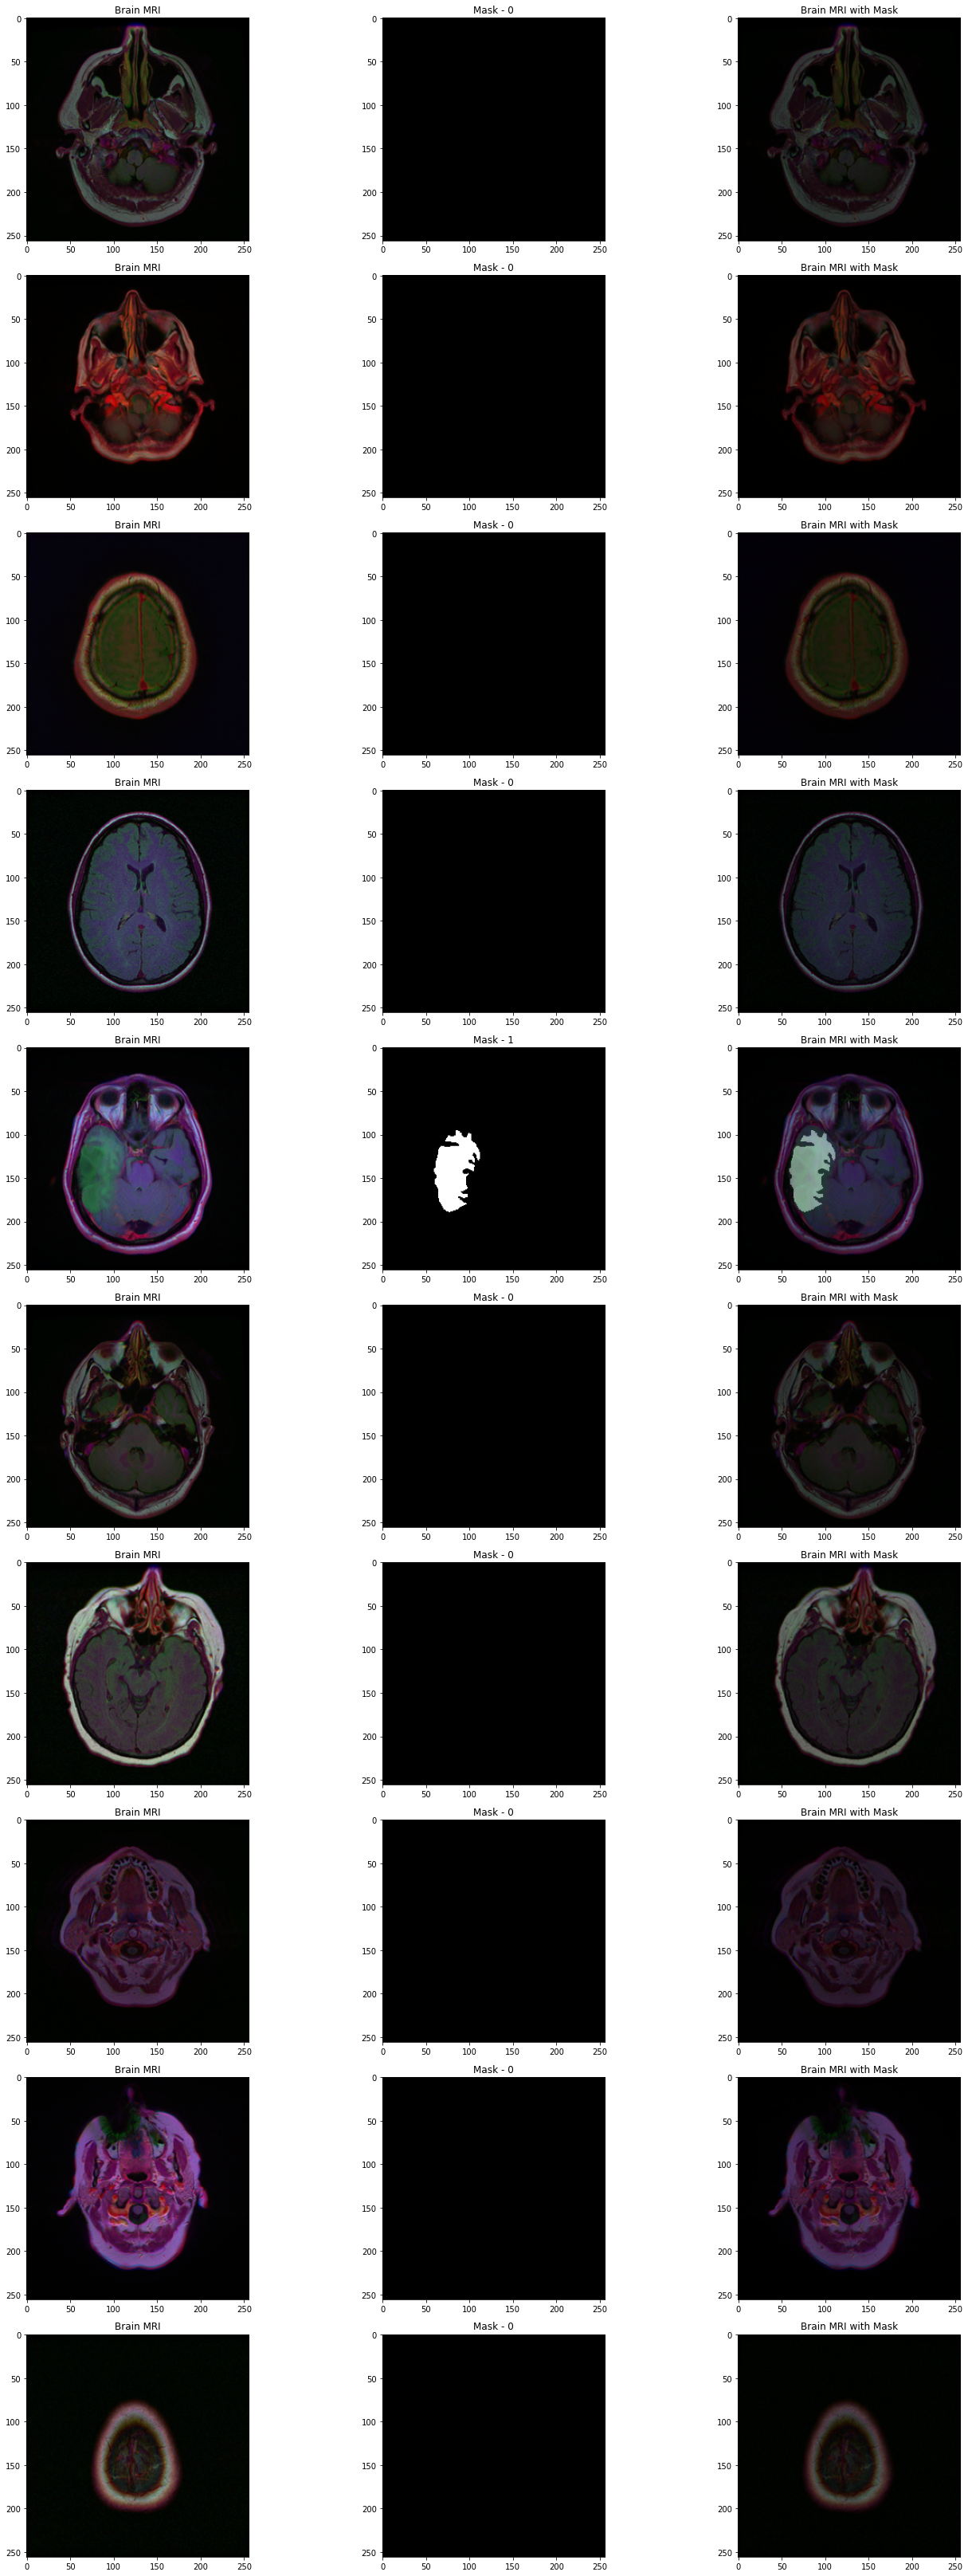

In [7]:
fig, ax = plt.subplots(10,3,figsize=(20,45))
for x in range(10):
    i = random.randint(0, len(df))
    img = cv2.imread(df['image_path'][i])
    mask = cv2.imread(df['mask_path'][i])
    ax[x][0].title.set_text("Brain MRI")
    ax[x][0].imshow(img)
    ax[x][1].title.set_text("Mask - " + str(df['mask'][i]))
    ax[x][1].imshow(mask)
    ax[x][2].title.set_text("Brain MRI with Mask")
    ax[x][2].imshow(img)
    ax[x][2].imshow(mask, alpha=0.4)
plt.tight_layout()

### Split data into Train, Validation and Test Set

In [8]:
df['mask'] = df['mask'].apply(lambda x: str(x))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [9]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.15)
df_train, df_val = train_test_split(df_train, test_size=0.15)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2838, 3)
(501, 3)
(590, 3)


## Model 1: A Classification Model to Detect if tumor or not

### Data Generator and Data Augmentation

In [10]:
datagen = ImageDataGenerator(rescale=1/255.)
train_generator = datagen.flow_from_dataframe(df_train, 
                                             x_col='image_path',
                                             y_col='mask',
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=True,
                                             target_size=IMAGE_SIZE)
validation_generator = datagen.flow_from_dataframe(df_val,
                                                  x_col='image_path',
                                                  y_col='mask',
                                                  class_mode='categorical',
                                                  batch_size=32,
                                                  shuffle=True,
                                                  target_size=IMAGE_SIZE)
test_generator = datagen.flow_from_dataframe(df_test,
                                            x_col='image_path',
                                            y_col='mask',
                                            class_mode='categorical',
                                            batch_size=32,
                                            shuffle=False,
                                            target_size=IMAGE_SIZE)

Found 2838 validated image filenames belonging to 2 classes.
Found 501 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


### Modeling

* Using ResNet50 as base model for Classification

In [11]:
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
# for layer in base_model.layers:
#     layer.trainable = False

x = base_model.output
x = AveragePooling2D(pool_size=(4,4))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(2, activation='softmax')(x)

clf_model = Model(base_model.input, outputs=x)
clf_model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
clf_model.summary()

94773248/94765736 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_____________________________

### Define Callbacks

In [12]:
es = EarlyStopping(monitor='val_loss',
                  mode='min',
                  verbose=1,
                  patience=10)
checkpoint = ModelCheckpoint(filepath='clf_model.hdf5',
                            verbose=1,
                            save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                             mode='min',
                             verbose=1,
                             patience=5,
                             min_denta=0.0001,
                             factor=0.2)
my_callbacks = [es, checkpoint, reduce_lr]

### Training model

In [13]:
history = clf_model.fit(train_generator,
                   epochs=50,
                   steps_per_epoch= train_generator.n // train_generator.batch_size,
                   validation_data=validation_generator,
                   validation_steps = validation_generator.n // validation_generator.batch_size,
                   callbacks=[checkpoint, es])

Epoch 1/50
88/88 [==============================] - 42s 337ms/step - loss: 0.9597 - accuracy: 0.6798 - val_loss: 1.6543 - val_accuracy: 0.6250

Epoch 00001: val_loss improved from inf to 1.65430, saving model to clf_model.hdf5
Epoch 2/50
88/88 [==============================] - 21s 235ms/step - loss: 0.4254 - accuracy: 0.8208 - val_loss: 0.8779 - val_accuracy: 0.6313

Epoch 00002: val_loss improved from 1.65430 to 0.87792, saving model to clf_model.hdf5
Epoch 3/50
88/88 [==============================] - 21s 235ms/step - loss: 0.2939 - accuracy: 0.8770 - val_loss: 0.6582 - val_accuracy: 0.6333

Epoch 00003: val_loss improved from 0.87792 to 0.65818, saving model to clf_model.hdf5
Epoch 4/50
88/88 [==============================] - 21s 235ms/step - loss: 0.4925 - accuracy: 0.8432 - val_loss: 0.9242 - val_accuracy: 0.6292

Epoch 00004: val_loss did not improve from 0.65818
Epoch 5/50
88/88 [==============================] - 21s 234ms/step - loss: 0.3739 - accuracy: 0.8534 - val_loss: 1.0

### Visualize the model performance

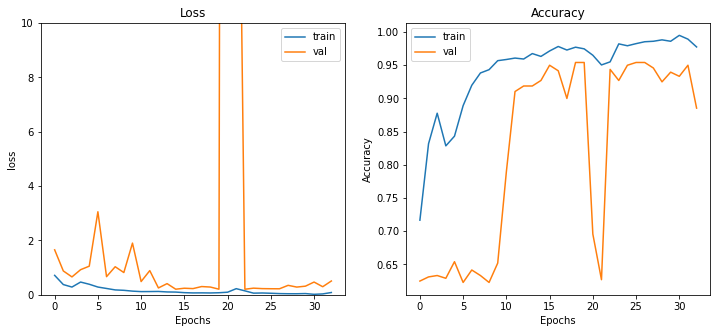

In [14]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylim((0, 10))
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['train','val'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

### Evaluate the model

In [15]:
clf_model.evaluate(test_generator)

19/19 [==============================] - 5s 275ms/step - loss: 0.4648 - accuracy: 0.8610


[0.46481820940971375, 0.8610169291496277]

Accuracy: 86.102
              precision    recall  f1-score   support

           0       0.94      0.84      0.89       385
           1       0.75      0.91      0.82       205

    accuracy                           0.86       590
   macro avg       0.85      0.87      0.85       590
weighted avg       0.88      0.86      0.86       590



<AxesSubplot:>

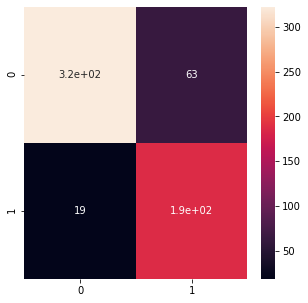

In [16]:
import seaborn as sns
preds = clf_model.predict(test_generator)
preds = np.argmax(preds, axis=1)
labels = np.asarray(df_test['mask']).astype('int')
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(labels, preds)
print("Accuracy: {:.3f}".format(accuracy*100))

cm = confusion_matrix(labels, preds)
report = classification_report(labels, preds, labels=[0,1])
print(report)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True)

## Model 2: Segementaion Model to localize tumor

### Data Generator, Data Augmentation and Adjust Data

In [17]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

### Define Loss function and Metrics

In [18]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

### Define UNet Model

* Using UNet Model for Brain MRI Segmentation

In [19]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

### Training

In [20]:
# Set parameters
EPOCHS = 150
BATCH_SIZE = 32
learning_rate = 1e-4

In [21]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=IMAGE_SIZE)
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
    
model = unet(input_size=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))



decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

callbacks = [ModelCheckpoint('unet_brainMRI_seg.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2838 validated image filenames.
Found 2838 validated image filenames.
Epoch 1/150
89/88 [==============================] - ETA: 0s - loss: -0.0704 - binary_accuracy: 0.7966 - iou: 0.0370 - dice_coef: 0.0704Found 501 validated image filenames.
Found 501 validated image filenames.
88/88 [==============================] - 105s 1s/step - loss: -0.0708 - binary_accuracy: 0.7978 - iou: 0.0372 - dice_coef: 0.0708 - val_loss: -0.0256 - val_binary_accuracy: 0.9894 - val_iou: 0.0131 - val_dice_coef: 0.0258

Epoch 00001: val_loss improved from inf to -0.02557, saving model to unet_brainMRI_seg.hdf5
Epoch 2/150
88/88 [==============================] - 84s 954ms/step - loss: -0.1629 - binary_accuracy: 0.9811 - iou: 0.0899 - dice_coef: 0.1629 - val_loss: -0.0567 - val_binary_accuracy: 0.9901 - val_iou: 0.0292 - val_dice_coef: 0.0562

Epoch 00002: val_loss improved from -0.02557 to -0.05675, saving model to unet_brainMRI_seg.hdf5
Epoch 3/150
88/88 [==============================] - 85s 957ms/st

### Visualize the model performance

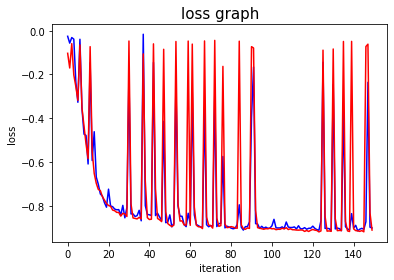

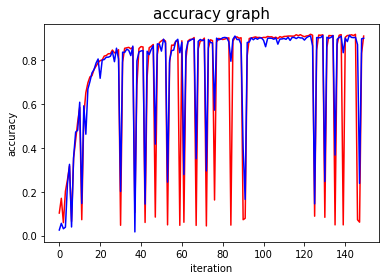

In [22]:
traindice = history.history['dice_coef']
testdice = history.history['val_dice_coef']

trainjaccard = history.history['iou']
testjaccard = history.history['val_iou']

trainloss = history.history['loss']
testloss = history.history['val_loss']
plt.figure(1)
plt.plot(testloss, 'b-')
plt.plot(trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(traindice, 'r-')
plt.plot(testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

### Evaluate the model

In [23]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 590 validated image filenames.
Found 590 validated image filenames.
18/18 [==============================] - 9s 500ms/step - loss: -0.8898 - binary_accuracy: 0.9980 - iou: 0.8078 - dice_coef: 0.8915
Test lost:  -0.889786422252655
Test IOU:  0.9979761242866516
Test Dice Coefficent:  0.8077689409255981


### Visualize the Result

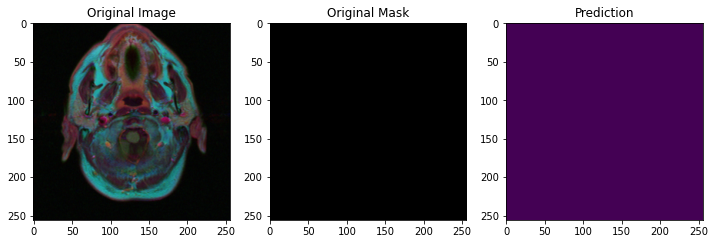

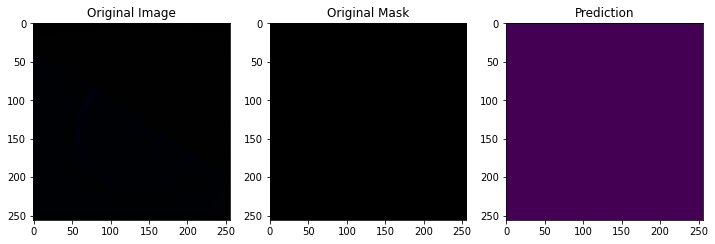

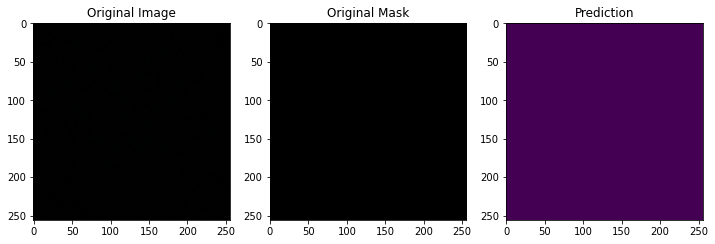

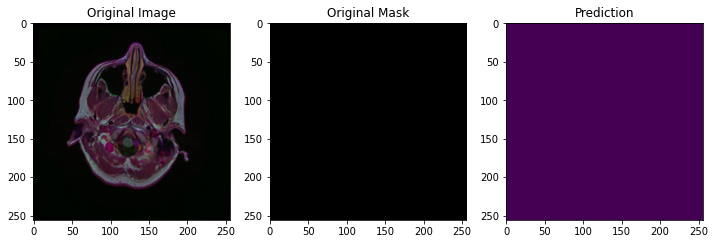

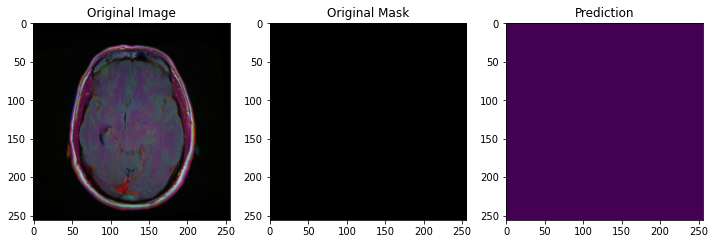

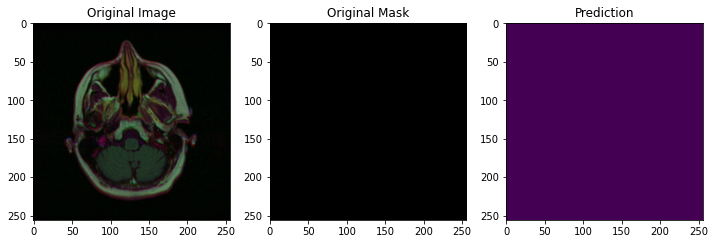

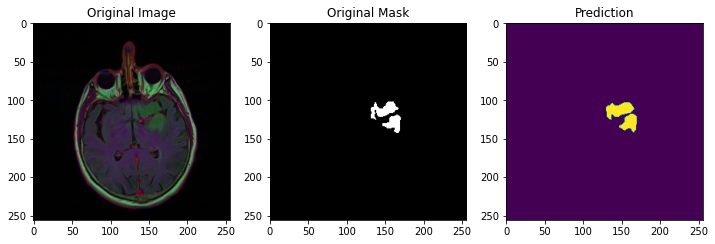

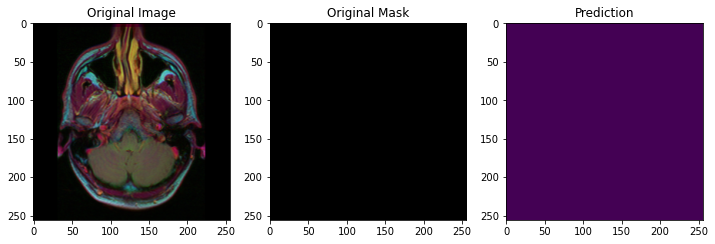

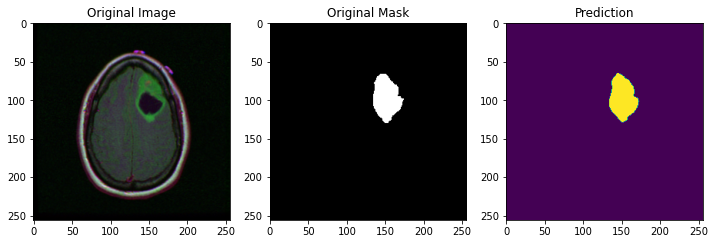

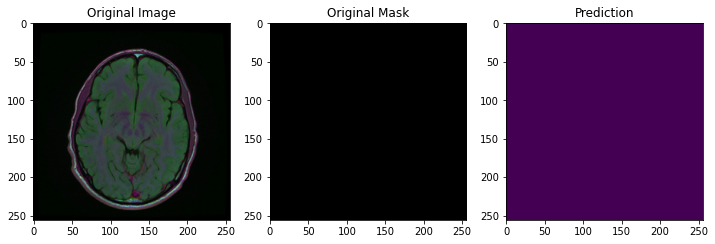

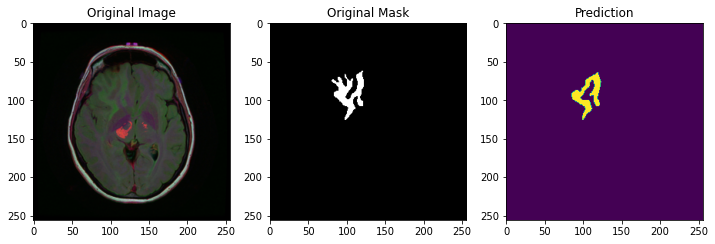

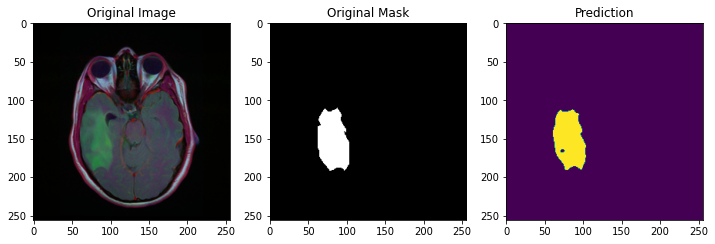

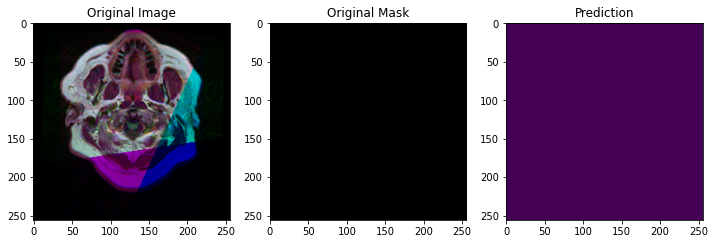

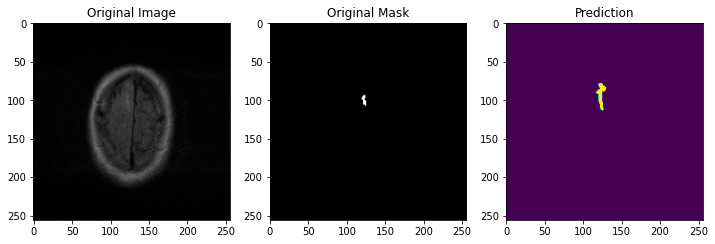

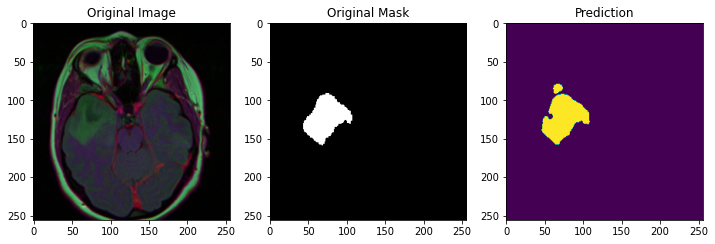

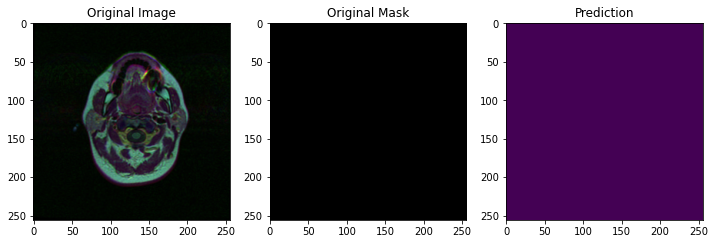

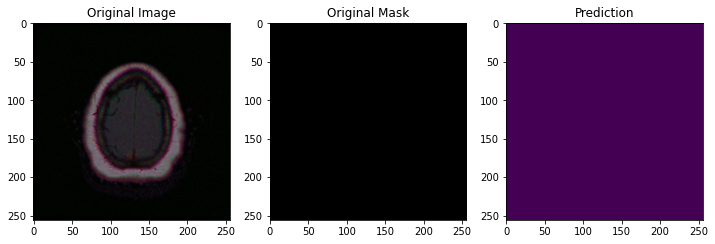

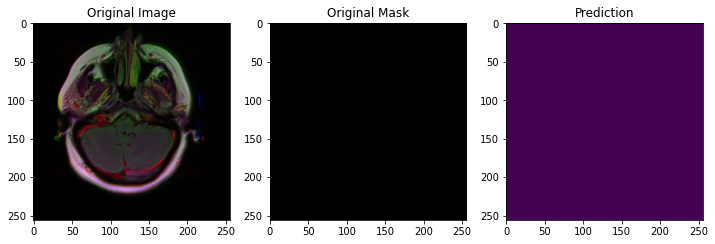

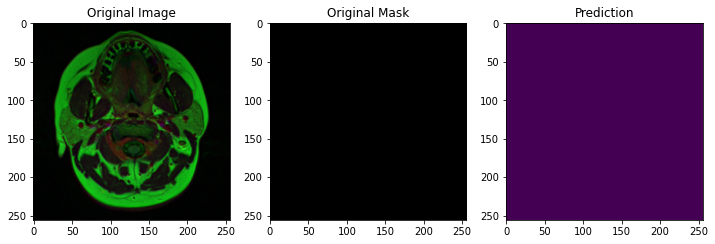

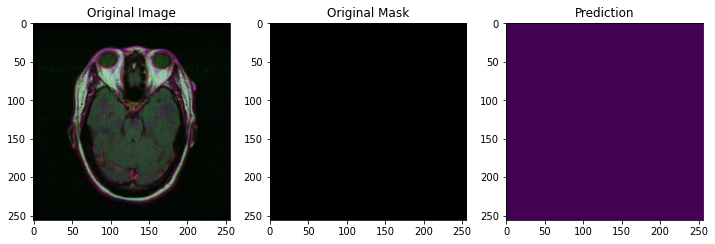

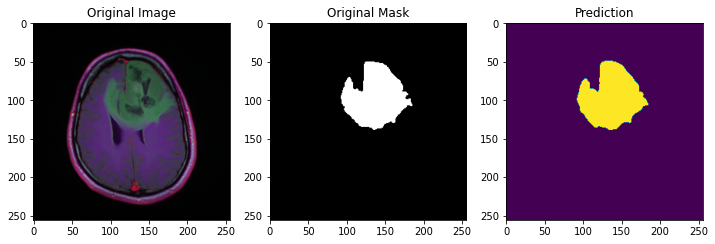

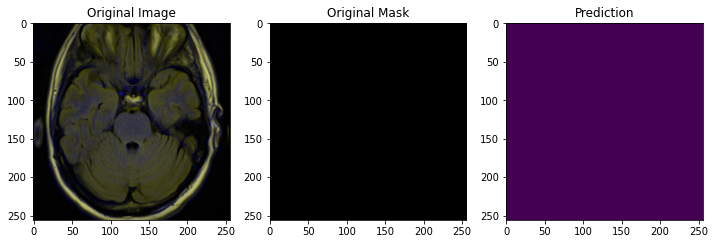

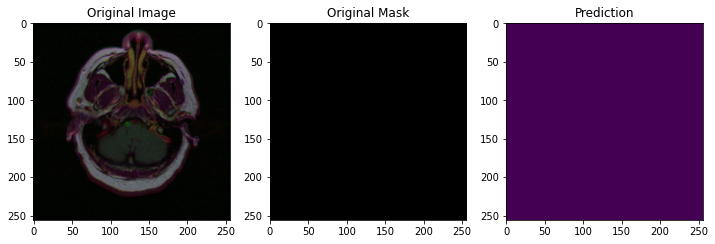

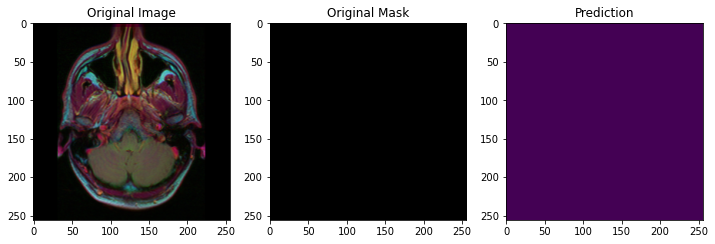

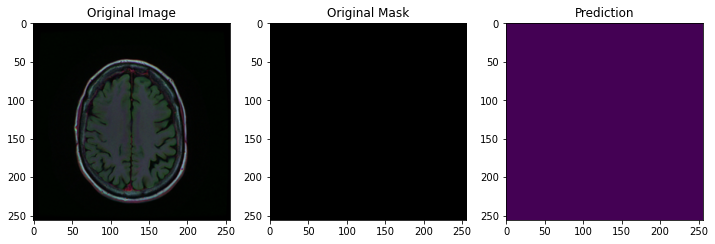

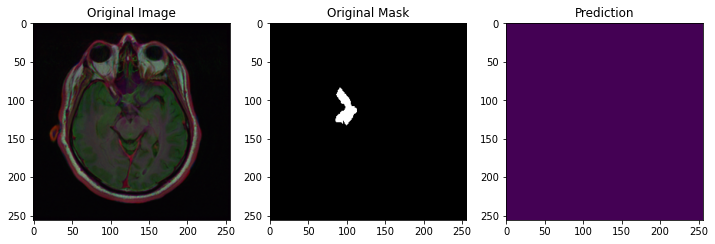

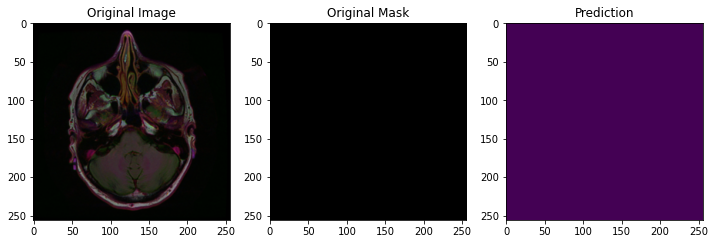

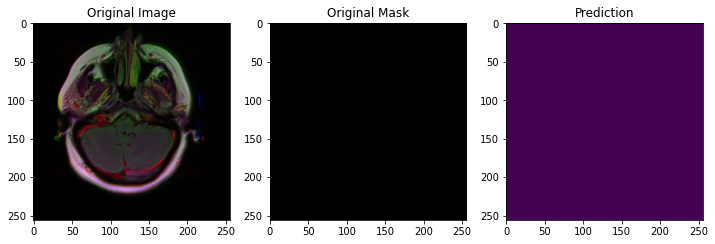

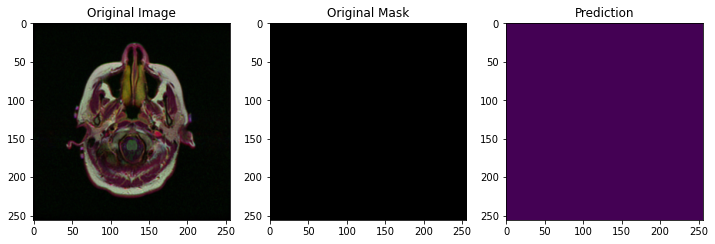

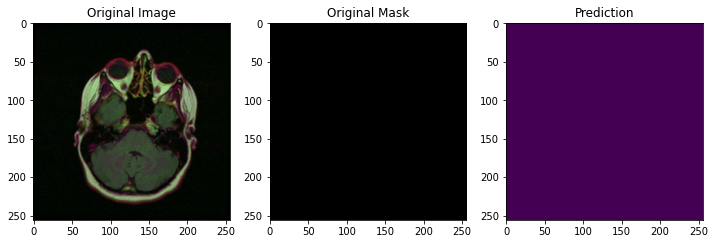

In [24]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['image_path'].iloc[index])
    img = cv2.resize(img ,IMAGE_SIZE)
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask_path'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()